# Model Tesla Options and GARCH

The goal of this notebook is to make a good prediction of what the average volatility will be in some horizon. We will use this volatility to predict opion prices for the Tesla stock and see if they deviate much from what the option price under Black Scholes would yield, if we used the volatility just the initial time. We get the data from yahoo finance.

The GARCH(p,q) model states as:

$$x_t= \varepsilon _t \sigma $$

$$\sigma ^2= a _0 + \sum \limits _{i = 1} ^p a_i x^2 _{t - p} + \sum \limits _{i = 1} ^p b_i \sigma^2 _{t - i} $$

In [1]:
import numpy as np
from random import gauss
import datetime
import yfinance as yf
import pandas as pd
import matplotlib .pyplot as plt
from arch import arch_model
from arch.univariate import EGARCH
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tabulate import tabulate
import itertools

from src.PricingFunctions import *
from src.greeks import *

### Get Data

In [2]:
tesla = yf.Ticker("TSLA")
start_date = datetime.datetime(2020, 1, 1)
end_date = datetime.datetime.now().date()
data = tesla.history(start=start_date, end=end_date)

In [3]:
returns = 100*data["Close"].pct_change().dropna()

In [4]:
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-01-02 00:00:00-05:00,28.299999,28.713333,28.114000,28.684000,142981500,0.0,0.0
2020-01-03 00:00:00-05:00,29.366667,30.266666,29.128000,29.534000,266677500,0.0,0.0
2020-01-06 00:00:00-05:00,29.364668,30.104000,29.333332,30.102667,151995000,0.0,0.0
2020-01-07 00:00:00-05:00,30.760000,31.441999,30.224001,31.270666,268231500,0.0,0.0
2020-01-08 00:00:00-05:00,31.580000,33.232666,31.215334,32.809334,467164500,0.0,0.0
...,...,...,...,...,...,...,...
2025-08-13 00:00:00-04:00,341.500000,348.980011,338.200012,339.380005,67838900,0.0,0.0
2025-08-14 00:00:00-04:00,335.760010,340.470001,330.399994,335.579987,75000700,0.0,0.0
2025-08-15 00:00:00-04:00,337.660004,339.299988,327.019989,330.559998,74319800,0.0,0.0


In [5]:
# We use the average of High and Low for each day to get a datapoint for each day
#dates = data.index
#highs = data["High"].to_numpy()
#lows = data["Low"].to_numpy()
data["log_returns"] = np.log(data["Close"] / data["Close"].shift(1))

data = data.dropna()

np.isnan(data["log_returns"]).any()

np.False_

In [6]:
N = 30
#dates4LogReturns = dates
#dates = dates[N :]
#values = values[N :]

In [7]:
hist_vol = data['log_returns'].rolling(window=30).std() * np.sqrt(252)
hist_vol.dropna()

Date
2020-02-14 00:00:00-05:00    0.975432
2020-02-18 00:00:00-05:00    0.985824
2020-02-19 00:00:00-05:00    0.994125
2020-02-20 00:00:00-05:00    1.000956
2020-02-21 00:00:00-05:00    0.999360
                               ...   
2025-08-13 00:00:00-04:00    0.479339
2025-08-14 00:00:00-04:00    0.462159
2025-08-15 00:00:00-04:00    0.464758
2025-08-18 00:00:00-04:00    0.412747
2025-08-19 00:00:00-04:00    0.416687
Name: log_returns, Length: 1385, dtype: float64

Text(0.5, 1.0, 'Historical Retruns for Tesla stock')

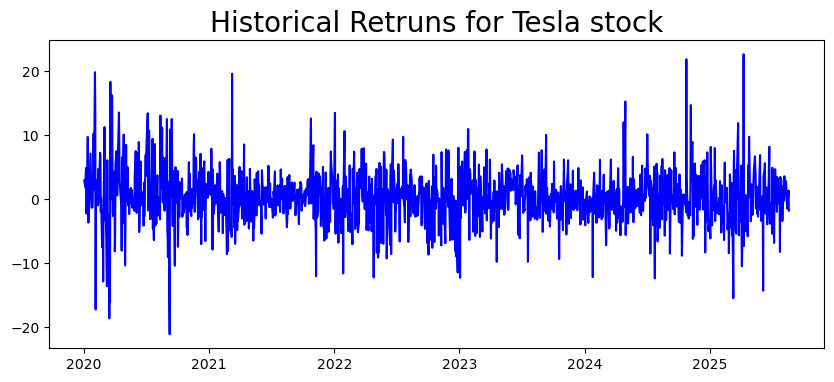

In [8]:
plt.figure(figsize=(10,4))
plt.plot(returns, 'b')
plt.title('Historical Retruns for Tesla stock', fontsize=20)

Text(0.5, 1.0, 'Historical Volatility for Tesla stock')

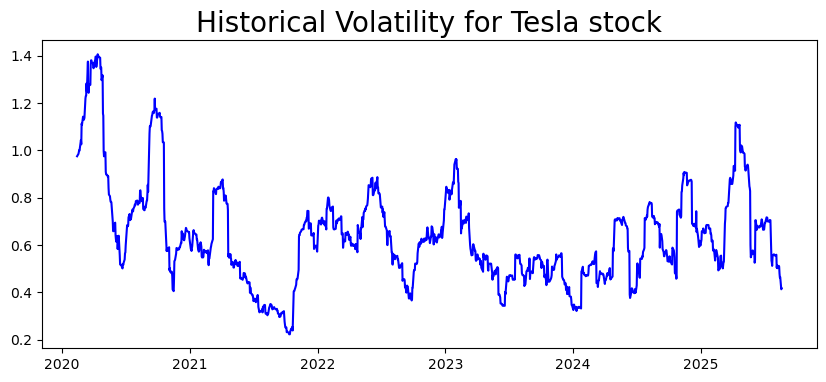

In [9]:
plt.figure(figsize=(10,4))
plt.plot(hist_vol, 'b')
plt.title('Historical Volatility for Tesla stock', fontsize=20)

Text(0.5, 1.0, 'Historical Log Returns for Tesla Stock')

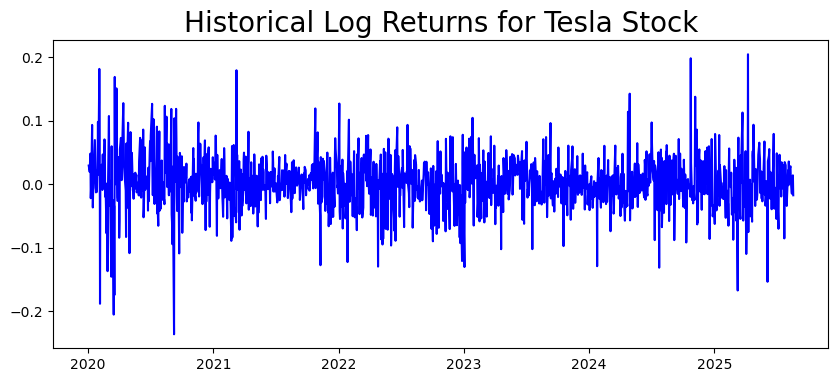

In [10]:
plt.figure(figsize=(10,4))
plt.plot(data["log_returns"], 'b')
plt.title('Historical Log Returns for Tesla Stock', fontsize=20)

## PACF plot

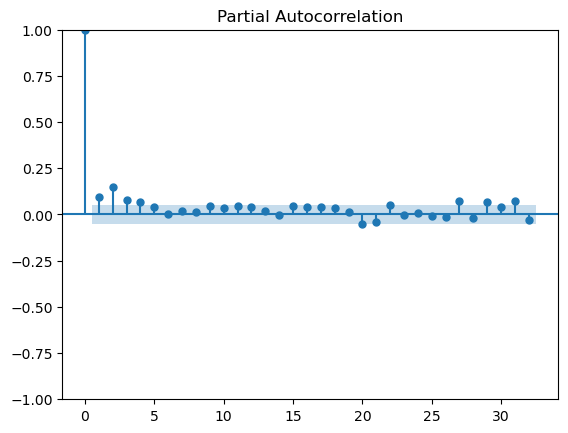

In [11]:
plot_pacf(np.array(data["log_returns"])**2)
plt.show()

## Try out various ARCH models and variations of ARCH models and select the model with the best AIC

Try out some models here

In [12]:
param_dist = ["gaussian", "ged", "t","generalized error", "skewt", "skewstudent", "studentst", "normal"]
param_vol = ["APARCH", "ARCH", "FIGARCH", "GARCH", "HARCH"]
param_p = [1,2,3,4,5,6]
param_q = [1,2,3,4,5,6]

best_aci = float("inf")   
best_params = None

In [13]:
searchForBestModel = False
if searchForBestModel:
    for dist, vol, p, q in itertools.product(param_dist, param_vol, param_p, param_q, ):
        try:
            model = arch_model(returns[:-150], vol=vol, p=p, q=q, dist=dist)
            model_fit = model.fit(disp="off")
            aci = model_fit.aic
        except :
            continue 

        if aci < best_aci:
            print(aci)
            best_aci = aci
            best_params = (dist, vol, p, q)


In [14]:
best_aci

inf

In [15]:
best_params

In [16]:
selectedModel = lambda trainingData : arch_model(trainingData, vol="GARCH", p=1, q=1, dist='ged')

In [17]:
model = selectedModel(returns)

In [18]:
model_fit = model.fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 5096167.837841177
Iteration:      2,   Func. Count:     16,   Neg. LLF: 9667.966594985039
Iteration:      3,   Func. Count:     26,   Neg. LLF: 41408.97813690641
Iteration:      4,   Func. Count:     33,   Neg. LLF: 3951.629563679342
Iteration:      5,   Func. Count:     40,   Neg. LLF: 3962.74494454428
Iteration:      6,   Func. Count:     48,   Neg. LLF: 4062.113445335174
Iteration:      7,   Func. Count:     55,   Neg. LLF: 4060.153925698334
Iteration:      8,   Func. Count:     62,   Neg. LLF: 3939.121700076892
Iteration:      9,   Func. Count:     69,   Neg. LLF: 3932.0404359610266
Iteration:     10,   Func. Count:     76,   Neg. LLF: 3931.27463531569
Iteration:     11,   Func. Count:     82,   Neg. LLF: 3931.2562922162806
Iteration:     12,   Func. Count:     88,   Neg. LLF: 3931.25301167374
Iteration:     13,   Func. Count:     94,   Neg. LLF: 3931.2531610346705
Iteration:     14,   Func. Count:    101,   Neg. LLF: 3931.25278

In [19]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Constant Mean - GARCH Model Results                            
==========================================================================================
Dep. Variable:                              Close   R-squared:                       0.000
Mean Model:                         Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                  GARCH   Log-Likelihood:               -3931.25
Distribution:      Generalized Error Distribution   AIC:                           7872.51
Method:                        Maximum Likelihood   BIC:                           7898.78
                                                    No. Observations:                 1414
Date:                            Wed, Aug 20 2025   Df Residuals:                     1413
Time:                                    01:50:27   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1661  6.116e-03     27.157 2.069e-162 [  0.154,  0.178]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.2665      0.191      1.395      0.163     [ -0.108,  0.641]
alpha[1]       0.0493  1.609e-02      3.065  2.179e-03 [1.778e-02,8.086e-02]
beta[1]        0.9358  2.244e-02     41.706      0.000     [  0.892,  0.980]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             1.1716  6.670e-02     17.565  4.557e-69 [  1.041,  1.302]
========================================================================

Covariance estimator: robust
"""

Tried out some and FIGARCH seems to perform best

## Rolling Forcast For Evaluation

In [20]:
rolling_predictions = []
test_size = 100
predictionHorizon = 10
numItterations = test_size//predictionHorizon + int(np.ceil(test_size/predictionHorizon - test_size//predictionHorizon).item())

for i in range(numItterations):
    train = returns[:-(test_size)+i*predictionHorizon]
    model = selectedModel(train)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=predictionHorizon)
    rolling_predictions = rolling_predictions + (np.sqrt(pred.variance.values[-1, :]) *np.sqrt(252)/100).tolist()

In [21]:
rolling_predictions = pd.Series(rolling_predictions[:test_size], index=data.index[-test_size:])

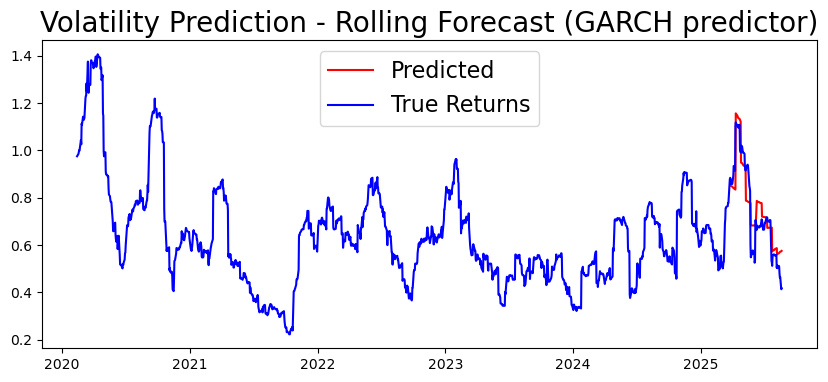

In [22]:
plt.figure(figsize=(10,4))
plt.plot(rolling_predictions, 'r')
plt.plot(hist_vol, 'b')

plt.title('Volatility Prediction - Rolling Forecast (GARCH predictor)', fontsize=20)
plt.legend([ 'Predicted','True Returns'], fontsize=16)

In [23]:
np.linalg.norm(rolling_predictions.to_numpy() - hist_vol[-test_size:]) /test_size

np.float64(0.008721309760408908)

In [24]:
np.max(np.abs(rolling_predictions.to_numpy() - hist_vol[-test_size:])) 

np.float64(0.2664122267200113)

## Naive Predictor where we set the volatility of today equal to the volatility of the next few days

In [25]:
rolling_predictions_Naive = []
test_size = 100
predictionHorizon = 10
numItterations = test_size//predictionHorizon + int(np.ceil(test_size/predictionHorizon - test_size//predictionHorizon).item())

for i in range(numItterations):
    train = hist_vol[:-(test_size)+i*predictionHorizon]
    predNaive = [train[-1].item()]*predictionHorizon
    rolling_predictions_Naive = rolling_predictions_Naive + predNaive

C:\Users\seand\AppData\Local\Temp\ipykernel_28700\3948807845.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predNaive = [train[-1].item()]*predictionHorizon


In [26]:
rolling_predictions_Naive = pd.Series(rolling_predictions_Naive[:test_size], index=data.index[-test_size:])

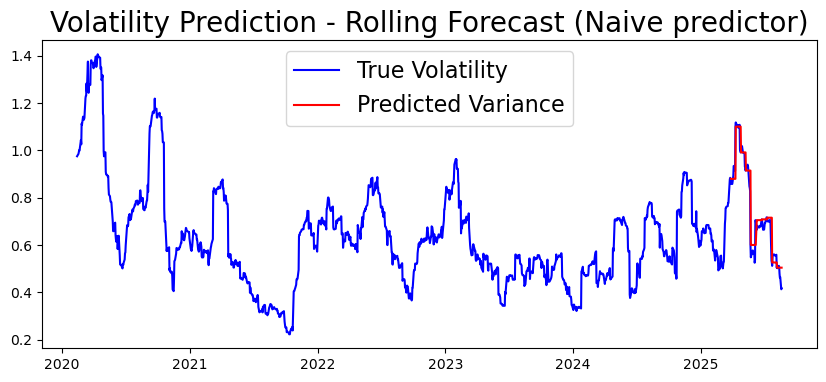

In [27]:
plt.figure(figsize=(10,4))
plt.plot(hist_vol, 'b')
preds, = plt.plot(rolling_predictions_Naive, "r")
plt.title('Volatility Prediction - Rolling Forecast (Naive predictor)', fontsize=20)
plt.legend(['True Volatility', 'Predicted Variance'], fontsize=16)

In [28]:
np.linalg.norm(rolling_predictions_Naive.to_numpy() - hist_vol[-test_size:])/test_size

np.float64(0.006110248381906126)

In [29]:
np.max(np.abs(rolling_predictions_Naive.to_numpy() - hist_vol[-test_size:]))

np.float64(0.31461284930866973)

#### Recap of what we did so far:

If you play around a little bit, then you can see that the GARCH model performs slightly better when predicting volatility with a larger horizon (measured with L2 and L infinity errors). However, it is important to say, that this is only one example, where this works, so it is hard to say, if this idea is really worth anything. And especially the p values from the summary indicate, that this is probably not significant and just overfited.

## Pricing European Tesla Options under Black Scholes with predicted volatility

In [30]:
def naive_volatilityPredictor(data:np.array):
    return data.iloc[-1]

In [31]:
def GARCH_volatilityPredictor(data:np.array, horizon = 10):
    model = selectedModel(data)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=horizon).variance.values[0,:]
    pred = np.sqrt(pred) *np.sqrt(252)/100
    return np.mean(pred).item()

Text(0.5, 1.0, 'Historical Tesla Stock at Close')

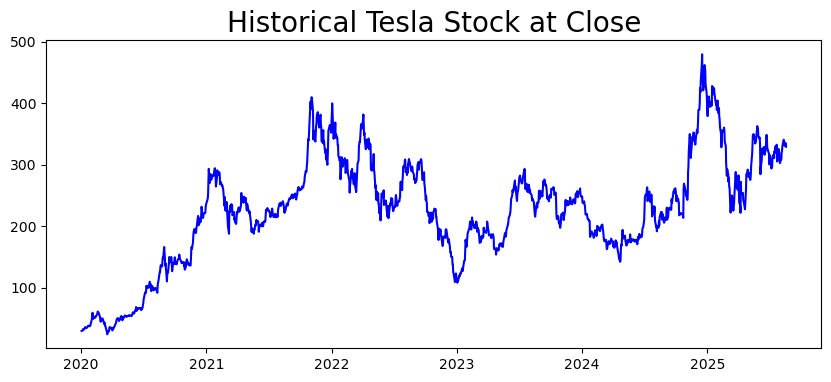

In [32]:
plt.figure(figsize=(10,4))
plt.plot(data["Close"], 'b')
plt.title('Historical Tesla Stock at Close', fontsize=20)

In [33]:
# Some data defining our option
# sigma has a higher impact on the BS pricing equation, when the horizon is large and when S/K is close to 1.
r = 0.04
t = 0
days = 100
T = days/252  
K = 350 # seems like a good choice for S/K close to 1


### Call

We focus on one european call option with maturity in 100 days. We want to know, what is the fair price. Black Scholes assumes a constant volatility and we want to know, if we can improve the price given by Black Scholes, if we plug in a "better" volatility, which is more representative for the entire horizon each day.

Let us plot the historical stock price:

In [34]:
naive_Volatility_BS_price_Call = []
GARCH_Volatility_BS_price_Call = []
for i in range(days):
    stockPrice = data["Close"].iloc[ -days + i]
    train = returns[ :-days + i]
    hist_vol_train = hist_vol[:-days + i]
    sigma_GARCH = GARCH_volatilityPredictor(train, days - i)
    sigma_Naive = naive_volatilityPredictor(hist_vol_train)

    priceGARCH = analyticEuropeanCall_BS(r,(t+i)/252,T,K,stockPrice,sigma_GARCH)
    priceNaive = analyticEuropeanCall_BS(r,t+i/252,T,K,stockPrice,sigma_Naive)

    naive_Volatility_BS_price_Call.append(priceNaive)
    GARCH_Volatility_BS_price_Call.append(priceGARCH)

In [35]:
naive_Volatility_BS_price_Call = pd.Series(naive_Volatility_BS_price_Call, index=data.index[-days-1:-1])
GARCH_Volatility_BS_price_Call = pd.Series(GARCH_Volatility_BS_price_Call, index=data.index[-days-1:-1])

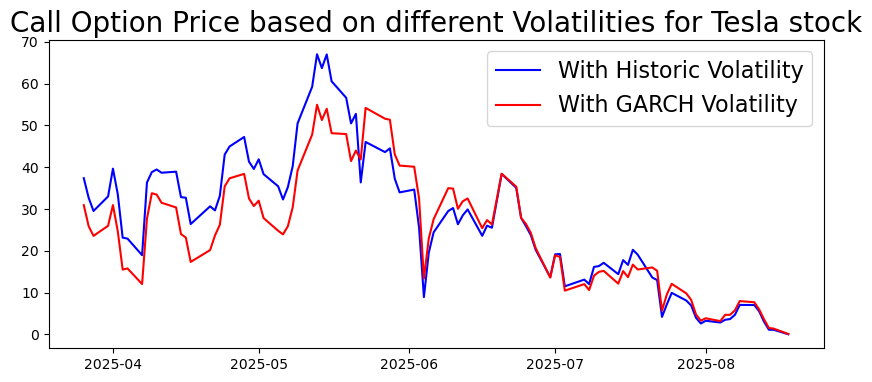

In [36]:
plt.figure(figsize=(10,4))
plt.plot(naive_Volatility_BS_price_Call, 'b')
plt.plot(GARCH_Volatility_BS_price_Call, 'r')
plt.title('Call Option Price based on different Volatilities for Tesla stock', fontsize=20)
plt.legend([ 'With Historic Volatility', 'With GARCH Volatility'], fontsize=16)

In [37]:
print(f"The actual value of the call option in the end was {np.maximum(data["Close"].iloc[ -1] - K, 0)}. So lets see which model did best on average.")
print(f"Mean option price based on GARCH           {np.mean(GARCH_Volatility_BS_price_Call).item()}")
print(f"Mean option price based on naive predictor {np.mean(naive_Volatility_BS_price_Call).item()}")

The actual value of the call option in the end was 0.0. So lets see which model did best on average.
Mean option price based on GARCH           24.37571844678319
Mean option price based on naive predictor 27.013567609334682


### Put

We do the same for a put option now.

In [38]:
naive_Volatility_BS_price_Put = []
GARCH_Volatility_BS_price_Put = []
for i in range(days):
    stockPrice = data["Close"].iloc[ -days + i]
    train = returns[ :-days + i]
    hist_vol_train = hist_vol[:-days + i]
    sigma_GARCH = GARCH_volatilityPredictor(train, days - i)
    sigma_Naive = naive_volatilityPredictor(hist_vol_train)

    priceGARCH = analyticEuropeanPut_BS(r,(t+i)/252,T,K,stockPrice,sigma_GARCH)
    priceNaive = analyticEuropeanPut_BS(r,t+i/252,T,K,stockPrice,sigma_Naive)

    naive_Volatility_BS_price_Put.append(priceNaive)
    GARCH_Volatility_BS_price_Put.append(priceGARCH)

In [39]:
naive_Volatility_BS_price_Put = pd.Series(naive_Volatility_BS_price_Put, index=data.index[-days-1:-1])
GARCH_Volatility_BS_price_Put = pd.Series(GARCH_Volatility_BS_price_Put, index=data.index[-days-1:-1])

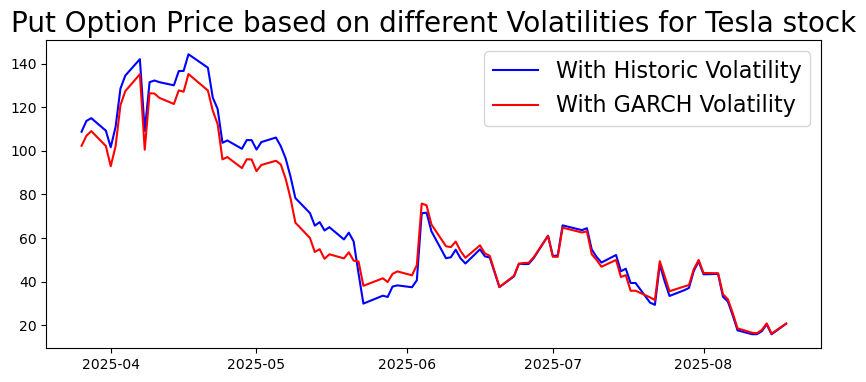

In [40]:
plt.figure(figsize=(10,4))
plt.plot(naive_Volatility_BS_price_Put, 'b', )
plt.plot(GARCH_Volatility_BS_price_Put, 'r')
plt.title('Put Option Price based on different Volatilities for Tesla stock', fontsize=20)
plt.legend([ 'With Historic Volatility', 'With GARCH Volatility'], fontsize=16)

In [41]:
print(f"The actual value of the call option in the end was {np.maximum(K- data["Close"].iloc[ -1], 0)}. So lets see which model did best on average.")
print(f"Mean option price based on GARCH           {np.mean(GARCH_Volatility_BS_price_Put).item()}")
print(f"Mean option price based on naive predictor {np.mean(naive_Volatility_BS_price_Put).item()}")

The actual value of the call option in the end was 20.69000244140625. So lets see which model did best on average.
Mean option price based on GARCH           65.11512226646504
Mean option price based on naive predictor 67.75297142901654


## Sanity Check: Let us see, if the price we get coincides +- with the actual market price of American options

Let us first see which option maturities we have

In [42]:
expiry_date_str = tesla.options[7]
tesla.options

('2025-08-22',
 '2025-08-29',
 '2025-09-05',
 '2025-09-12',
 '2025-09-19',
 '2025-09-26',
 '2025-10-17',
 '2025-11-21',
 '2025-12-19',
 '2026-01-16',
 '2026-02-20',
 '2026-03-20',
 '2026-05-15',
 '2026-06-18',
 '2026-07-17',
 '2026-08-21',
 '2026-09-18',
 '2026-12-18',
 '2027-01-15',
 '2027-06-17',
 '2027-12-17')

In [43]:
expiry_date_str

'2025-11-21'

In [44]:
# compute time left
expiry_date = datetime.datetime.strptime(expiry_date_str, "%Y-%m-%d").date()
today = datetime.datetime.now().date()
time_left = (expiry_date - today).days / 365 # devided by 365 because with datetime we also counted non banikng days.

In [45]:
option_chain = tesla.option_chain(expiry_date_str)

In [46]:
calls = option_chain.calls
puts = option_chain.puts

Let us fix a maturity

In [47]:
calls_WStrike_we_want = calls[calls['strike'] == K]

In [48]:
calls_WStrike_we_want

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
50,TSLA251121C00350000,2025-08-19 19:52:40+00:00,350.0,27.35,27.2,27.35,-2.75,-9.136212,542,7070,0.532567,False,REGULAR,USD


In [49]:
puts_WStrike_we_want = puts[puts['strike'] == K]

In [50]:
#calls_WStrike_we_want = calls_WStrike_we_want.tail(1)
price_call_market = calls_WStrike_we_want["lastPrice"].item()

In [51]:
# we are using only the implied volatility of the call here, since for the put it is almost equal to zero due to causes of volatility skew, such as demand and supply, e.g. not many people buy puts for the tesla stock (at this strike).
impliedVol = calls_WStrike_we_want["impliedVolatility"].item()
impliedVol

0.5325669302368164

In [52]:
price_put_market = puts_WStrike_we_want["lastPrice"].item()

In [53]:
time_left *365

93.0

In [54]:
sigma_GARCH = GARCH_volatilityPredictor(returns.to_numpy(),int(time_left *365))
sigma_Naive = naive_volatilityPredictor(hist_vol_train)
lastStockPrice = data["Close"].tail(1)

# We use the european price for the call option, since it is never optimal to execute a call with no dividends and positive interest rate
price_GARCH_put = price_american_option_binomial(lastStockPrice, K, T, r, sigma_GARCH, 100, option_type='put')
price_GARCH_call = analyticEuropeanCall_BS(S=lastStockPrice, K=K,t=0, T=time_left, r=r, sigma=sigma_GARCH)

price_Naive_put =  price_american_option_binomial(lastStockPrice, K, T, r, sigma_Naive, 100, option_type='put')
price_Naive_call = analyticEuropeanCall_BS(S=lastStockPrice, K=K,t=0, T=time_left, r=r, sigma=sigma_Naive)

c:\Users\seand\git\QuantCodingProjects\src\PricingFunctions.py:85: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  asset_prices[i] = S * (u**(n - i)) * (d**i)
c:\Users\seand\git\QuantCodingProjects\src\PricingFunctions.py:107: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  option_values[j] = np.maximum(continuation_value, exercise_value)


In [55]:
print("PRICES TODAY VALUED WITH DIFFERENT METHODS:")
print(tabulate([['call', price_call_market, price_GARCH_call, price_Naive_call], ['put', price_put_market, price_GARCH_put, price_Naive_put]], headers=['call/put','Market', 'BS GARCH', 'BS Historic Vol']))
print("__________________________________________________________________________________")
print("ABSOLUTE DIFFERENCE MARKET PRICES VS OUR MODELS:")
print(tabulate([['call', np.abs(price_call_market- price_GARCH_call ), np.abs(price_call_market-price_Naive_call )], ['put', np.abs(price_put_market - price_GARCH_put), np.abs(price_put_market - price_Naive_put)]], headers=['call/put', 'BS GARCH - Market Price', 'BS Historic Vol - Market Price']))

PRICES TODAY VALUED WITH DIFFERENT METHODS:
call/put      Market    BS GARCH    BS Historic Vol
----------  --------  ----------  -----------------
call           27.35     31.214             20.2864
put            43.42     57.2479            43.645
__________________________________________________________________________________
ABSOLUTE DIFFERENCE MARKET PRICES VS OUR MODELS:
call/put      BS GARCH - Market Price    BS Historic Vol - Market Price
----------  -------------------------  --------------------------------
call                          3.86401                           7.06356
put                          13.8279                            0.22501


In [56]:
print("VOLATILITIES TODAY VALUED WITH DIFFERENT METHODS:")
print(tabulate([ [impliedVol, sigma_GARCH **2, sigma_Naive**2]], headers=['Implied Volatility', 'GARCH', 'Last Historic Volatility']))
print("__________________________________________________________________________________")
print("ABSOLUTE DIFFERENCE MARKET PRICES VS OUR MODELS:")
print(tabulate([['call', np.abs(impliedVol- sigma_GARCH**2 ), np.abs(impliedVol-sigma_Naive**2 )]], headers=['|GARCH Vol - Implied Vol|', '|Historic Vol - Implied Vol|']))

VOLATILITIES TODAY VALUED WITH DIFFERENT METHODS:
  Implied Volatility     GARCH    Last Historic Volatility
--------------------  --------  --------------------------
            0.532567  0.334245                     0.17036
__________________________________________________________________________________
ABSOLUTE DIFFERENCE MARKET PRICES VS OUR MODELS:
        |GARCH Vol - Implied Vol|    |Historic Vol - Implied Vol|
----  ---------------------------  ------------------------------
call                     0.198322                        0.362207


**Takeaway:** 

We build two models for pricing options based on historic volatility.

The price of the BS price with histroic volatility seems to be closer to the actual price, but the GARCH volatility seems to be closer to the implied volatility.

Also the GARCH volatility in our model seems so give us a greater price with BS than the current market price. So we now would like to build a portfolio with this knowledge to make some money out of it.

(This strategy won't make any money in practice, but this is just to explore some methods in python)

## Let's build a Delta and Gamma Neutral Portfolio with our Prediction

We saw, that our price prediction of the put option is higher, than the current market price. Thus we want to figure out, how we can monitize this, by building a delta and gamma hedged portfolio.
To compute the Delta for our options, we again rely on the Black Scholes framework. In practice, it may be preferable to implement this with finite differences, but for that we need multiple data points over time. Thus to keep things simple we just use BS. (And for American puts we use the binomial model.)

In [88]:
def giveNum_CallsPuts_toBuy(delta_Put, delta_Call, gamma_Put, gamma_Call, capital_To_Invest, price_Put, price_Call, price_Stock):
    """
    Delta and Gamma hedged portfolio build out of Call option, put option and stock.
    """
    portionCall = - gamma_Put / gamma_Call
    portionPut = 1
    portionStock = delta_Call * gamma_Put / gamma_Call - delta_Put
    scalingFactor = capital_To_Invest / (price_Put + portionCall *price_Call + portionStock*price_Stock)
    numStock = np.floor(portionStock *scalingFactor)
    numPuts = np.floor(portionPut *scalingFactor)
    numCalls = np.floor(portionCall *scalingFactor)

    return {"numPuts":numPuts, "numCalls":numCalls, "numStock":numStock, "investedCapital": numCalls*price_Call + numPuts* price_Put + numStock*price_Stock, "EffectiveDelta": numCalls*delta_Call + numPuts* delta_Put + numStock, "EffectiveGamma": numCalls*gamma_Call + numPuts* gamma_Put}

In [119]:
deltaPut = american_put_delta_binomial(r=r,  T=T, K=K, S0=lastStockPrice, sigma = sigma_GARCH, n = 100).item()
deltaCall = deltaEuropean_BS(r=r, t=0, T=T, K=K, S=lastStockPrice, sigma=sigma_GARCH, option_type='call').item()
gammaPut = american_put_gamma_binomial(S0=lastStockPrice, K=K, T=T, r=r, sigma=sigma_GARCH, N= 100).item()
gammaCall = black_scholes_gamma(S=lastStockPrice ,K=K, T=T, r=r, sigma = sigma_GARCH).to_numpy().item()
capitalToInvest = 1_000_000
pricePut = price_put_market
priceCall = price_call_market

c:\Users\seand\git\QuantCodingProjects\src\greeks.py:77: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  stock_prices[0, 0] = S0
c:\Users\seand\git\QuantCodingProjects\src\greeks.py:128: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  stock_prices[i, j] = S0 * (u ** j) * (d ** (i - j))


In [120]:
giveNum_CallsPuts_toBuy(delta_Put = deltaPut, delta_Call = deltaCall, gamma_Put = gammaPut, gamma_Call =gammaCall, capital_To_Invest = capitalToInvest, price_Put = pricePut, price_Call = priceCall, price_Stock = lastStockPrice.to_numpy().item())

{'numPuts': np.float64(2770.0),
 'numCalls': np.float64(-2866.0),
 'numStock': np.float64(2909.0),
 'investedCapital': np.float64(999851.0828979493),
 'EffectiveDelta': np.float64(-0.45250051449602324),
 'EffectiveGamma': np.float64(-0.004683442109881142)}

This means that we need to sell Calls and buy Puts and stock shares according to the result from above.



## Final Thoughts:

In practice we would need to take care of some more things. 
First of all the GARCH model we used is too far away from the implied volatility and we have no reason to actually believe, that the implied volatiliy is wrong besides from differing from what the model yielded.

Second, the implied volatility from an option not only depends on the volatility of the stock, but also depends on more factors, e.g. if it is a call or put, strike, maturity, etc. We only assumed one volatiliy to be true, namely the one we predicted.

Third, the way we computed the greeks here was in the framework of the BS and Binomial model. While being nice in theory, this does not necessarily align with what the real delta and gamma of the options looks like. This could be calculated exactly, by computing the greeks with actual partial derivatives (e.g. with finite differences, central differences, etc.). Unfortunately, I couldn't find historical option price data to compute this